# ECMO_RL Project

## Loading the ECMO data

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

np.set_printoptions(threshold=np.inf)
pd.option_context('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [4]:
ECMO_data = pd.read_csv('../../generated data/ECMO_data_all_flow_sweep.csv')
ECMO_mortality = pd.read_csv('../../generated data/ECMO_mortality.csv')

In [5]:
ECMO_mortality

,ENCOUNTER_NBR,mortality_in_hospital
0,51525846011,1
1,51704076032,0
2,51733536034,1
3,51760726039,0
4,46491676043,0
...,...,...
216,69900791287,0
217,70341401291,0
218,70666401306,0
219,2178911314,0


In [4]:
ECMO_data = pd.read_csv('../generated data/ECMO_data_all_flow_sweep.csv')
sedation_data = pd.read_excel("../ECMO Rass and CAM-ICU.xlsx")

ECMO_data["merge_key"] = pd.to_datetime(ECMO_data["merge_key"])
sedation_data["Service Timestamp"] = pd.to_datetime(sedation_data["Service Timestamp"])
ECMO_data["csn"]=ECMO_data["csn"].astype('int64')

sedation_data.rename(columns={"Encounter": "csn", "Service Timestamp": "merge_key"}, inplace=True)
rass_score = sedation_data[sedation_data["Structured Result Type"] == "RASS Scale"]
rass_score.drop(columns="Structured Result Type", inplace=True)

CAM_ICU = sedation_data[sedation_data["Structured Result Type"] == "CAM-ICU Overall"]
CAM_ICU.drop(columns="Structured Result Type", inplace=True)

Text_Result = []
for num in rass_score["Text Result"]:
    try:
        Text_Result.append(int(num.split(" ")[0]))
    except:
        Text_Result.append(0)
rass_score["Text Result"] = Text_Result

# Sort ECMO_data by 'merge_key'
ECMO_data.sort_values(by='merge_key', inplace=True)
rass_score.sort_values(by='merge_key', inplace=True)
rass_score.rename(columns={"Text Result": "rass_score"}, inplace=True)

ECMO_data = pd.merge_asof(ECMO_data, rass_score, on='merge_key', by='csn', direction='nearest')


Text_Result = []
for num in CAM_ICU["Text Result"]:
    if num == 'Positive':
        Text_Result.append(int(1))
    elif num == 'Negative':
        Text_Result.append(int(0))
    else:
        Text_Result.append(np.nan)
CAM_ICU["Text Result"] = Text_Result
CAM_ICU.rename(columns={"Text Result": "CAM_ICU"}, inplace=True)
CAM_ICU = pd.concat([CAM_ICU.csn, CAM_ICU.groupby('csn').ffill()], axis = 1)

CAM_ICU.sort_values(by='merge_key', inplace=True)
ECMO_data = pd.merge_asof(ECMO_data, CAM_ICU, on='merge_key', by='csn', direction='nearest')

In [5]:
ECMO_data

,Unnamed: 0,csn,ECMO Pump Flow,ECMO Sweep Gas Flow,recorded_time_flow_sweep,merge_key,temperature,daily_weight_kg,height_cm,sbp_line,...,SOFA_resp,SOFA_resp_sa,hourly_total,delta_24h,hourly_total_mod,delta_24h_mod,recorded_time_sofa,recorded_time_data,rass_score,CAM_ICU
0,13898,52278286092,4.57,5.0,2016-04-27 07:00:00,2016-04-27 07:00:00,37.20,98.9,177.8,146.0,...,3.0,2.0,12.0,0.0,7.0,0.0,2016-04-27 07:00:00,2016-04-27 07:00:00,-3,1.0
1,13899,52278286092,4.71,5.0,2016-04-27 08:00:00,2016-04-27 08:00:00,37.00,98.9,177.8,118.0,...,3.0,2.0,8.0,0.0,3.0,0.0,2016-04-27 08:00:00,2016-04-27 08:00:00,-3,1.0
2,14026,52461796114,4.96,6.0,2016-04-27 08:00:00,2016-04-27 08:00:00,37.00,122.6,167.6,124.0,...,3.0,2.0,8.0,0.0,3.0,0.0,2016-04-27 08:00:00,2016-04-27 08:00:00,-4,0.0
3,13900,52278286092,4.7,5.0,2016-04-27 09:00:00,2016-04-27 09:00:00,37.00,98.9,177.8,128.0,...,3.0,2.0,8.0,0.0,3.0,0.0,2016-04-27 09:00:00,2016-04-27 09:00:00,-3,1.0
4,14027,52461796114,4.96,6.0,2016-04-27 09:00:00,2016-04-27 09:00:00,37.00,122.6,167.6,120.0,...,3.0,2.0,8.0,0.0,3.0,0.0,2016-04-27 09:00:00,2016-04-27 09:00:00,-4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60490,60490,70840791325,6.26,11.0,2021-12-07 12:00:00,2021-12-07 12:00:00,36.35,104.1,177.0,125.5,...,NaN,NaN,4.0,0.0,4.0,0.0,2021-12-07 12:00:00,2021-12-07 12:00:00,-2,0.0
60491,60491,70840791325,6.28,11.0,2021-12-07 13:00:00,2021-12-07 13:00:00,36.30,104.1,177.0,114.5,...,NaN,NaN,4.0,0.0,4.0,0.0,2021-12-07 13:00:00,2021-12-07 13:00:00,-2,0.0
60492,60492,70840791325,6.21,11.0,2021-12-07 14:00:00,2021-12-07 14:00:00,36.30,104.1,177.0,147.0,...,NaN,NaN,4.0,0.0,4.0,0.0,2021-12-07 14:00:00,2021-12-07 14:00:00,-2,0.0
60493,60493,70840791325,6.13,11.0,2021-12-07 15:00:00,2021-12-07 15:00:00,36.30,104.1,177.0,0.0,...,NaN,NaN,5.0,0.0,5.0,0.0,2021-12-07 15:00:00,2021-12-07 15:00:00,-2,0.0


## Preprocessing

#### Feature selection

In [6]:
features = [
    'csn', #drop
    'temperature', 'map_line', 
    'map_cuff', 'pulse', 'unassisted_resp_rate',  
    'end_tidal_co2', 'o2_flow_rate', 'base_excess', 'bicarb_(hco3)', 
    'blood_urea_nitrogen_(bun)', 
    'creatinine', 'phosphorus', 
    'hemoglobin', 'met_hgb', 'platelets', 
    'white_blood_cell_count', 'carboxy_hgb', 'alanine_aminotransferase_(alt)', 
    'ammonia', 'aspartate_aminotransferase_(ast)', 
    'bilirubin_total', 'fibrinogen', 'inr', 'lactate_dehydrogenase', 'lactic_acid', 
    'partial_prothrombin_time_(ptt)', 'prealbumin', 
    'lipase', 'b-type_natriuretic_peptide_(bnp)', 
    'partial_pressure_of_carbon_dioxide_(paco2)', 
    'ph', 'saturation_of_oxygen_(sao2)',    
    'procalcitonin', 'erythrocyte_sedimentation_rate_(esr)',  
    'gcs_total_score', 'best_map',
    'pf_sp', 'pf_pa', 'spo2', 'partial_pressure_of_oxygen_(pao2)',
    'rass_score', 'CAM_ICU']

# sedation levels, lung injury variables
# RASS (more reliable than gcs) CAMICU (delirium score)
# minute ventalition 


#    'norepinephrine_dose_weight', 'epinephrine_dose_weight', 'procedure',
#    'dobutamine_dose_weight', 'dopamine_dose_weight', 'phenylephrine_dose_weight', 'vasopressin_dose_weight'

not_used_features = [
    'daily_weight_kg', 'height_cm', 'sbp_line', 'dbp_line', 'sbp_cuff', 'dbp_cuff', 'calcium', 'calcium_ionized', 
    'anion_gap', 'c_diff', 'norepinephrine_dose_unit', 'epinephrine_dose_unit', 'dobutamine_dose_unit', 
    'calcium_adjusted', 'haptoglobin', 'prothrombin_time_(pt)', 'thrombin_time', 'transferrin', 'chloride', 
    'thyroid_stimulating_hormone_(tsh)', 'crp_high_sens', 'covid', 'mtp', 'parathyroid_level', 'gfr',
    'dopamine_dose_unit', 'phenylephrine_dose_unit', 'vasopressin_dose_unit', 'glucose', 'magnesium', 'osmolarity',
    'potassium', 'sodium', 'hematocrit', 'albumin', 'alkaline_phosphatase', 'bilirubin_direct', 'protein', 
    'amylase', 'troponin', 'd_dimer', 'hemoglobin_a1c', 'gcs_eye_score', 'gcs_verbal_score', 'gcs_motor_score',
    'vent_status', 'norepinephrine', 'epinephrine', 'dobutamine', 'dopamine', 'phenylephrine', 'vasopressin', 
    'icu', 'imc', 'ed' 

]

actions = [
    'csn', 
    'vent_start_time', 'vent_stop_time', 'vent_rate_set', 'peep', 'fio2', 'ECMO Pump Flow', 'ECMO Sweep Gas Flow',
]

not_used_actions = [
    'vent_mode', 'vent_type', 'vent_tidal_rate_set', 'vent_tidal_rate_exhaled'
]

scores = [
    'csn',
    'SOFA_renal', 'SOFA_cardio', 'SOFA_resp'
]

scores_not_used = [
        'SOFA_coag', 'SOFA_hep', 'SOFA_neuro', 'SOFA_cardio_mod', 
        'SOFA_resp_sa', 'hourly_total', 'delta_24h', 'hourly_total_mod',
       'delta_24h_mod'
]

In [7]:
ECMO_data_features = ECMO_data[features]
ECMO_data_actions = ECMO_data[actions]

In [8]:
ECMO_data_actions['ECMO Sweep Gas Flow'] = pd.to_numeric(ECMO_data_actions['ECMO Sweep Gas Flow'], errors='coerce').dropna()
ECMO_data_actions['ECMO Pump Flow'] = pd.to_numeric(ECMO_data_actions['ECMO Pump Flow'], errors='coerce').dropna()

In [9]:
mortality_csn = set(ECMO_data[scores]['csn']) - set(ECMO_mortality['ENCOUNTER_NBR'])
new_rows = pd.DataFrame({'ENCOUNTER_NBR': list(mortality_csn), 'mortality_in_hospital': [0]*len(mortality_csn)})
ECMO_mortality_updated = pd.concat([ECMO_mortality, new_rows],  ignore_index=True)

In [41]:
ECMO_mortality

,ENCOUNTER_NBR,mortality_in_hospital
0,51525846011,1
1,51704076032,0
2,51733536034,1
3,51760726039,0
4,46491676043,0
...,...,...
216,69900791287,0
217,70341401291,0
218,70666401306,0
219,2178911314,0


In [10]:
ECMO_data_scores = ECMO_data[scores].merge(ECMO_mortality_updated, left_on='csn', right_on='ENCOUNTER_NBR')
ECMO_data_scores = ECMO_data_scores.drop(columns=['ENCOUNTER_NBR'])

### TabelOne

In [11]:
ECMO_data = pd.read_csv('../generated data/ECMO_data_states_actions_scores.csv')
demo_data = pd.read_csv('../generated data/ECMO_data_states_actions_scores_full_table_one.csv')

In [12]:
data = demo_data.merge(ECMO_mortality_updated, left_on='csn', right_on='ENCOUNTER_NBR')
demo_data = data[['age','race','gender', 'mortality_in_hospital','csn']].groupby('csn').first()

In [39]:
demo_data

,age,race,gender,mortality_in_hospital
csn,,,,
43640203,28,African American or Black,Male,0
2178911314,67,African American or Black,Male,0
2207761225,31,African American or Black,Female,0
4510511039,49,Caucasian or White,Male,0
6648317299,65,African American or Black,Female,1
...,...,...,...,...
70321991269,32,Asian,Female,0
70341401291,28,Caucasian or White,Male,0
70454151283,35,Caucasian or White,Male,0


In [16]:
from tableone import TableOne
columns = ['daily_weight_kg', 'height_cm', 'temperature', 'map_line', 
    'map_cuff', 'pulse', 'unassisted_resp_rate',  
    'end_tidal_co2', 'o2_flow_rate', 'base_excess', 'bicarb_(hco3)', 
    'blood_urea_nitrogen_(bun)', 
    'creatinine', 'phosphorus', 
    'hemoglobin', 'met_hgb', 'platelets', 
    'white_blood_cell_count', 'carboxy_hgb', 'alanine_aminotransferase_(alt)', 
    'ammonia', 'aspartate_aminotransferase_(ast)', 
    'bilirubin_total', 'fibrinogen', 'inr', 'lactate_dehydrogenase', 'lactic_acid', 
    'partial_prothrombin_time_(ptt)', 'prealbumin', 
    'lipase', 'b-type_natriuretic_peptide_(bnp)', 
    'partial_pressure_of_carbon_dioxide_(paco2)', 
    'ph', 'saturation_of_oxygen_(sao2)',    
    'procalcitonin', 'erythrocyte_sedimentation_rate_(esr)',  
    'gcs_total_score', 
    'procedure', 'best_map',
    'pf_sp', 'pf_pa', 'spo2', 'partial_pressure_of_oxygen_(pao2)',  
    'vent_rate_set', 'peep', 'fio2','SOFA_renal', 'SOFA_cardio', 'SOFA_resp']

data = ECMO_data.merge(ECMO_mortality_updated, left_on='csn', right_on='ENCOUNTER_NBR')
mytable = TableOne(data, columns, groupby = 'mortality_in_hospital', categorical=[], pval = True)

mytable2 = TableOne(demo_data, columns=['age','race','gender'], groupby = 'mortality_in_hospital', categorical=['race','gender'], pval = True)


Grouped by mortality_in_hospital                                               
                                                                           Missing      Overall            0            1 P-Value
n                                                                                           202          139           63        
age, mean (SD)                                                                   0  45.2 (13.6)  43.6 (13.6)  48.8 (13.1)   0.011
race, n (%)    African American  or Black                                        0    78 (38.6)    54 (38.8)    24 (38.1)   0.784
               Asian                                                                    6 (3.0)      4 (2.9)      2 (3.2)        
               Caucasian or White                                                     75 (37.1)    49 (35.3)    26 (41.3)        
               Unknown, Unavailable or Unreported                                     43 (21.3)    32 (23.0)    11 (17.5)        
gender, n (%)  Female                                                            0    86 (42.6)    58 (41.7)    28 (44.4)   0.835
               Male                                                                  116 (57.4)    81 (58.3)    35 (55.6)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: race.

In [17]:
mytable

Grouped by mortality_in_hospital                                                       
                                                                                Missing         Overall              0               1 P-Value
n                                                                                                 71389          41637           29752        
daily_weight_kg, mean (SD)                                                           14    104.4 (54.9)   106.6 (37.4)    101.3 (72.4)  <0.001
height_cm, mean (SD)                                                               3757     172.2 (9.8)   172.9 (10.2)     171.3 (9.2)  <0.001
temperature, mean (SD)                                                              115      36.8 (0.5)     36.8 (0.5)      36.7 (0.5)  <0.001
map_line, mean (SD)                                                                1449     82.6 (12.9)    83.3 (12.9)     81.5 (12.9)  <0.001
map_cuff, mean (SD)                                                               45192     86.4 (14.8)    87.1 (14.2)     85.6 (15.3)  <0.001
pulse, mean (SD)                                                                     19     94.2 (17.6)    95.2 (17.8)     92.9 (17.2)  <0.001
unassisted_resp_rate, mean (SD)                                                      54      19.4 (7.8)     19.0 (7.5)      20.0 (8.2)  <0.001
end_tidal_co2, mean (SD)                                                          36521     25.5 (13.2)    27.7 (12.8)     21.4 (12.8)  <0.001
o2_flow_rate, mean (SD)                                                           66270     14.8 (15.9)    12.7 (13.5)     19.1 (19.4)  <0.001
base_excess, mean (SD)                                                            68689       0.8 (6.6)      1.6 (5.5)      -0.1 (7.5)  <0.001
bicarb_(hco3), mean (SD)                                                           6886      27.9 (5.2)     27.6 (4.8)      28.4 (5.7)  <0.001
blood_urea_nitrogen_(bun), mean (SD)                                               8642     42.4 (26.4)    43.7 (28.3)     40.5 (23.3)  <0.001
creatinine, mean (SD)                                                              8863       1.2 (1.0)      1.3 (1.1)       1.1 (0.9)  <0.001
phosphorus, mean (SD)                                                             13659       3.8 (1.3)      4.0 (1.3)       3.6 (1.3)  <0.001
hemoglobin, mean (SD)                                                              7338       8.9 (1.2)      8.9 (1.3)       8.9 (1.1)   0.079
met_hgb, mean (SD)                                                                27265       0.5 (0.5)      0.4 (0.3)       0.5 (0.7)  <0.001
platelets, mean (SD)                                                               6702    159.6 (84.1)   178.3 (86.8)    133.1 (72.4)  <0.001
white_blood_cell_count, mean (SD)                                                  6998      14.8 (7.4)     14.4 (7.1)      15.3 (7.7)  <0.001
carboxy_hgb, mean (SD)                                                            27222       1.1 (1.1)      0.9 (0.8)       1.5 (1.3)  <0.001
alanine_aminotransferase_(alt), mean (SD)                                         15704   100.6 (384.2)   77.4 (237.5)   131.8 (518.0)  <0.001
ammonia, mean (SD)                                                                67985     77.1 (47.5)    66.6 (19.1)     82.2 (55.6)  <0.001
aspartate_aminotransferase_(ast), mean (SD)                                       15882  173.7 (1008.3)  100.9 (444.8)  274.8 (1461.4)  <0.001
bilirubin_total, mean (SD)                                                        15890       1.9 (3.5)      1.4 (1.6)       2.7 (5.1)  <0.001
fibrinogen, mean (SD)                                                             17529   431.4 (209.9)  458.6 (217.0)   387.5 (189.8)  <0.001
inr, mean (SD)                                                                    18131       1.4 (0.5)      1.4 (0.4)       1.5 (0.6)  <0.001
lactate_dehydrogenase, mean (SD)                   

## windowing

In [18]:
def apply_sliding_window(group):
    processed_rows = []
    
    for i in range(0, len(group), 4):
        if i + 4 <= len(group):
            window_df = group.iloc[i:i+4]
        else:
            window_df = group.iloc[i:]
        
        mean_values = window_df.mean().to_dict()
        mean_values['csn'] = group['csn'].iloc[0]
        processed_rows.append(mean_values)
    
    return pd.DataFrame(processed_rows)

In [19]:
grouped_features = ECMO_data_features.groupby('csn')
ECMO_data_features_4_hour = pd.concat([apply_sliding_window(group) for _, group in grouped_features])
ECMO_data_features_4_hour.reset_index(drop=True, inplace=True)
ECMO_data_features_4_hour

,csn,temperature,map_line,map_cuff,pulse,unassisted_resp_rate,end_tidal_co2,o2_flow_rate,base_excess,bicarb_(hco3),...,procalcitonin,erythrocyte_sedimentation_rate_(esr),gcs_total_score,best_map,pf_sp,pf_pa,spo2,partial_pressure_of_oxygen_(pao2),rass_score,CAM_ICU
0,43640203,37.5000,99.333333,95.4,111.400000,NaN,40.555556,NaN,NaN,24.016667,...,NaN,NaN,3.0,99.333333,303.125000,67.000000,93.425000,67.0,-4.00,1.00
1,43640203,36.8500,83.250000,95.0,91.750000,NaN,37.500000,NaN,NaN,23.725000,...,0.5,NaN,3.0,83.250000,94.625000,69.500000,94.625000,69.5,-3.25,1.00
2,43640203,36.2500,86.333333,95.0,92.125000,17.500000,35.791667,NaN,NaN,24.425000,...,0.5,NaN,3.0,86.333333,93.916667,74.000000,93.916667,74.0,-3.00,1.00
3,43640203,36.5500,78.375000,80.0,117.500000,17.250000,30.125000,NaN,0.0,22.975000,...,0.5,NaN,7.5,78.375000,93.875000,70.500000,93.875000,70.5,-2.25,0.25
4,43640203,37.3500,81.791667,86.0,146.000000,19.000000,31.875000,NaN,0.0,26.300000,...,0.5,NaN,12.0,84.625000,152.252747,154.299451,98.750000,100.0,0.75,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15187,70840791325,36.5500,75.125000,NaN,86.000000,24.000000,NaN,60.0,NaN,NaN,...,NaN,NaN,10.0,75.125000,NaN,NaN,87.750000,NaN,-2.00,0.00
15188,70840791325,36.2500,66.583333,NaN,88.250000,23.500000,NaN,60.0,NaN,NaN,...,NaN,NaN,10.0,66.583333,NaN,NaN,87.208333,NaN,-2.00,0.00
15189,70840791325,36.5500,67.822917,NaN,89.239583,24.035714,NaN,60.0,NaN,NaN,...,NaN,NaN,10.0,67.822917,NaN,NaN,86.756944,NaN,-2.00,0.00
15190,70840791325,36.4875,76.416667,NaN,100.166667,18.833333,NaN,60.0,NaN,NaN,...,NaN,NaN,10.0,76.416667,NaN,NaN,80.500000,NaN,-2.00,0.00


In [20]:
grouped_actions = ECMO_data_actions[['csn','vent_rate_set','peep','fio2','ECMO Pump Flow', 'ECMO Sweep Gas Flow']].groupby('csn')
ECMO_data_actions_4_hour = pd.concat([apply_sliding_window(group) for _, group in grouped_actions])
ECMO_data_actions_4_hour.reset_index(drop=True, inplace=True)
ECMO_data_actions_4_hour

,csn,vent_rate_set,peep,fio2,ECMO Pump Flow,ECMO Sweep Gas Flow
0,43640203,10.0,16.0,0.55,5.077500,9.50
1,43640203,10.0,16.0,1.00,5.417500,10.00
2,43640203,10.0,16.0,1.00,5.652500,10.00
3,43640203,10.0,16.0,1.00,6.225000,10.00
4,43640203,10.0,16.0,0.60,6.405000,10.00
...,...,...,...,...,...,...
15187,70840791325,NaN,NaN,NaN,5.942500,10.00
15188,70840791325,NaN,NaN,NaN,5.920000,10.00
15189,70840791325,NaN,NaN,NaN,5.907500,10.25
15190,70840791325,NaN,NaN,NaN,6.202500,11.00


In [21]:
grouped_scores = ECMO_data_scores.groupby('csn')
ECMO_data_scores_4_hour = pd.concat([apply_sliding_window(group) for _, group in grouped_scores])
ECMO_data_scores_4_hour.reset_index(drop=True, inplace=True)
ECMO_data_scores_4_hour

,csn,SOFA_renal,SOFA_cardio,SOFA_resp,mortality_in_hospital
0,43640203,1.0,0.00,4.0,0.0
1,43640203,0.5,0.00,4.0,0.0
2,43640203,0.0,0.00,4.0,0.0
3,43640203,0.0,3.00,4.0,0.0
4,43640203,0.0,4.00,3.0,0.0
...,...,...,...,...,...
15187,70840791325,NaN,4.00,NaN,1.0
15188,70840791325,0.0,4.00,NaN,1.0
15189,70840791325,0.0,2.75,NaN,1.0
15190,70840791325,0.0,0.00,NaN,1.0


#### Data imputation

In [22]:
ECMO_data_features_imputed_4_hour = ECMO_data_features_4_hour.groupby('csn').ffill().bfill().fillna(ECMO_data_features.mean())
ECMO_data_features_imputed_4_hour

,temperature,map_line,map_cuff,pulse,unassisted_resp_rate,end_tidal_co2,o2_flow_rate,base_excess,bicarb_(hco3),blood_urea_nitrogen_(bun),...,procalcitonin,erythrocyte_sedimentation_rate_(esr),gcs_total_score,best_map,pf_sp,pf_pa,spo2,partial_pressure_of_oxygen_(pao2),rass_score,CAM_ICU
0,37.5000,99.333333,95.4,111.400000,17.500000,40.555556,6.0,0.000000,24.016667,44.0,...,0.500000,28.000000,3.0,99.333333,303.125000,67.000000,93.425000,67.000000,-4.00,1.00
1,36.8500,83.250000,95.0,91.750000,17.500000,37.500000,6.0,0.000000,23.725000,43.5,...,0.500000,28.000000,3.0,83.250000,94.625000,69.500000,94.625000,69.500000,-3.25,1.00
2,36.2500,86.333333,95.0,92.125000,17.500000,35.791667,6.0,0.000000,24.425000,43.0,...,0.500000,28.000000,3.0,86.333333,93.916667,74.000000,93.916667,74.000000,-3.00,1.00
3,36.5500,78.375000,80.0,117.500000,17.250000,30.125000,6.0,0.000000,22.975000,43.0,...,0.500000,28.000000,7.5,78.375000,93.875000,70.500000,93.875000,70.500000,-2.25,0.25
4,37.3500,81.791667,86.0,146.000000,19.000000,31.875000,6.0,0.000000,26.300000,43.0,...,0.500000,28.000000,12.0,84.625000,152.252747,154.299451,98.750000,100.000000,0.75,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15187,36.5500,75.125000,81.0,86.000000,24.000000,0.000000,60.0,1.124234,24.000000,25.0,...,6.478012,15.945946,10.0,75.125000,145.555556,234.879583,87.750000,101.879397,-2.00,0.00
15188,36.2500,66.583333,81.0,88.250000,23.500000,0.000000,60.0,1.124234,24.000000,22.0,...,6.478012,15.945946,10.0,66.583333,145.555556,234.879583,87.208333,101.879397,-2.00,0.00
15189,36.5500,67.822917,81.0,89.239583,24.035714,0.000000,60.0,1.124234,24.000000,22.0,...,6.478012,15.945946,10.0,67.822917,145.555556,234.879583,86.756944,101.879397,-2.00,0.00
15190,36.4875,76.416667,81.0,100.166667,18.833333,0.000000,60.0,1.124234,24.000000,22.0,...,6.478012,15.945946,10.0,76.416667,145.555556,234.879583,80.500000,101.879397,-2.00,0.00


In [23]:
ECMO_data_actions_imputed_4_hour = ECMO_data_actions_4_hour.groupby('csn').ffill().bfill() # check backward fill
ECMO_data_actions_imputed_4_hour

,vent_rate_set,peep,fio2,ECMO Pump Flow,ECMO Sweep Gas Flow
0,10.0,16.0,0.55,5.077500,9.50
1,10.0,16.0,1.00,5.417500,10.00
2,10.0,16.0,1.00,5.652500,10.00
3,10.0,16.0,1.00,6.225000,10.00
4,10.0,16.0,0.60,6.405000,10.00
...,...,...,...,...,...
15187,10.0,10.0,0.40,5.942500,10.00
15188,10.0,10.0,0.40,5.920000,10.00
15189,10.0,10.0,0.40,5.907500,10.25
15190,10.0,10.0,0.40,6.202500,11.00


### calculate short-term reward

In [24]:
ECMO_data_scores_imputed_4_hour = ECMO_data_scores_4_hour.groupby('csn').ffill().bfill().fillna(ECMO_data_scores.mean()) # change to median later
ECMO_data_scores_imputed_4_hour['SOFA_sigma'] = ECMO_data_scores_imputed_4_hour['SOFA_renal'] + ECMO_data_scores_imputed_4_hour['SOFA_cardio'] \
                                         + (2 * ECMO_data_scores_imputed_4_hour['SOFA_resp'])
ECMO_data_scores_imputed_4_hour

,SOFA_renal,SOFA_cardio,SOFA_resp,mortality_in_hospital,SOFA_sigma
0,1.0,0.00,4.000000,0.0,9.000000
1,0.5,0.00,4.000000,0.0,8.500000
2,0.0,0.00,4.000000,0.0,8.000000
3,0.0,3.00,4.000000,0.0,11.000000
4,0.0,4.00,3.000000,0.0,10.000000
...,...,...,...,...,...
15187,1.0,4.00,2.266597,1.0,9.533193
15188,0.0,4.00,2.266597,1.0,8.533193
15189,0.0,2.75,2.266597,1.0,7.283193
15190,0.0,0.00,2.266597,1.0,4.533193


In [38]:
ECMO_data_actions_imputed_4_hour['csn'] = ECMO_data_actions_4_hour['csn']
ECMO_data_actions_imputed_4_hour.to_csv("non_discritised_data.csv",index=False)

#### Action discritization

In [25]:
ECMO_data_actions_imputed_discrite_4_hour = ECMO_data_actions_imputed_4_hour.copy()
#fio2_ranges = [(-float('inf'), 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6),
#               (0.6, 0.7), (0.7, float('inf'))]

fio2_ranges = [(-float('inf'), 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, float('inf'))]

#peep_ranges = [(-float('inf'), 5), (5, 7), (7, 9), (9, 11),
#               (11, 13), (13, 15), (15, float('inf'))]

peep_ranges = [(-float('inf'), 7), (7, 9), (9, 11), (11, 13), (13, float('inf'))]

#vent_rate_set_ranges = [(-float('inf'), 12), (12, 15), (15, 18), (18, 21),
#               (21, 24), (24, float('inf'))]

vent_rate_set_ranges = [(-float('inf'), 15), (15, 18), (18, 21), (21, float('inf'))]

sweep_ranges = [(-float('inf'), 2.5), (2.5, 5), (5, 7.5), (7.5, 10), (10, float('inf'))]

flow_ranges = [(-float('inf'), 3), (3, 4), (4, 5), (5, 6), (6, float('inf'))]

# 4*5*4*5*5 = 2000*35

def categorize_fio2(row):
    for i, (low, high) in enumerate(fio2_ranges):
        if low <= row['fio2'] < high:
            return i
    return len(fio2_ranges) - 1

def categorize_peep(row):
    for i, (low, high) in enumerate(peep_ranges):
        if low <= row['peep'] < high:
            return i
    return len(peep_ranges) - 1

def categorize_vent_rate_set(row):
    for i, (low, high) in enumerate(vent_rate_set_ranges):
        if low <= row['vent_rate_set'] < high:
            return i
    return len(vent_rate_set_ranges) - 1

def categorize_sweep(row):
    for i, (low, high) in enumerate(sweep_ranges):
        if low <= row['ECMO Sweep Gas Flow'] < high:
            return i
    return len(sweep_ranges) - 1

def categorize_flow(row):
    for i, (low, high) in enumerate(flow_ranges):
        if low <= row['ECMO Pump Flow'] < high:
            return i
    return len(flow_ranges) - 1

def update_fio2_columns(row):
    index = row['fio2_range_index']
    column_name = f'fio2_range_{int(index)}'
    row[column_name] = 1
    return row

def update_peep_columns(row):
    index = row['peep_range_index']
    column_name = f'peep_range_{int(index)}'
    row[column_name] = 1
    return row

def update_vent_rate_set_columns(row):
    index = row['vent_rate_set_range_index']
    column_name = f'vent_rate_set_range_{int(index)}'
    row[column_name] = 1
    return row

def update_sweep_columns(row):
    index = row['sweep_range_index']
    column_name = f'sweep_range_{int(index)}'
    row[column_name] = 1
    return row

def update_flow_columns(row):
    index = row['flow_range_index']
    column_name = f'flow_range_{int(index)}'
    row[column_name] = 1
    return row


for i, _ in enumerate(fio2_ranges):
    ECMO_data_actions_imputed_discrite_4_hour[f'fio2_range_{i}'] = 0
ECMO_data_actions_imputed_discrite_4_hour['fio2_range_index'] = ECMO_data_actions_imputed_discrite_4_hour.apply(categorize_fio2, axis=1)
ECMO_data_actions_imputed_discrite_4_hour = ECMO_data_actions_imputed_discrite_4_hour.apply(update_fio2_columns, axis=1)
ECMO_data_actions_imputed_discrite_4_hour.drop('fio2_range_index', axis=1, inplace=True)

for i, _ in enumerate(peep_ranges):
    ECMO_data_actions_imputed_discrite_4_hour[f'peep_range_{i}'] = 0
ECMO_data_actions_imputed_discrite_4_hour['peep_range_index'] = ECMO_data_actions_imputed_discrite_4_hour.apply(categorize_peep, axis=1)
ECMO_data_actions_imputed_discrite_4_hour = ECMO_data_actions_imputed_discrite_4_hour.apply(update_peep_columns, axis=1)
ECMO_data_actions_imputed_discrite_4_hour.drop('peep_range_index', axis=1, inplace=True)

for i, _ in enumerate(vent_rate_set_ranges):
    ECMO_data_actions_imputed_discrite_4_hour[f'vent_rate_set_range_{i}'] = 0
ECMO_data_actions_imputed_discrite_4_hour['vent_rate_set_range_index'] = ECMO_data_actions_imputed_discrite_4_hour.apply(categorize_vent_rate_set, axis=1)
ECMO_data_actions_imputed_discrite_4_hour = ECMO_data_actions_imputed_discrite_4_hour.apply(update_vent_rate_set_columns, axis=1)
ECMO_data_actions_imputed_discrite_4_hour.drop('vent_rate_set_range_index', axis=1, inplace=True)

for i, _ in enumerate(sweep_ranges):
    ECMO_data_actions_imputed_discrite_4_hour[f'sweep_range_{i}'] = 0
ECMO_data_actions_imputed_discrite_4_hour['sweep_range_index'] = ECMO_data_actions_imputed_discrite_4_hour.apply(categorize_sweep, axis=1)
ECMO_data_actions_imputed_discrite_4_hour = ECMO_data_actions_imputed_discrite_4_hour.apply(update_sweep_columns, axis=1)
ECMO_data_actions_imputed_discrite_4_hour.drop('sweep_range_index', axis=1, inplace=True)

for i, _ in enumerate(flow_ranges):
    ECMO_data_actions_imputed_discrite_4_hour[f'flow_range_{i}'] = 0
ECMO_data_actions_imputed_discrite_4_hour['flow_range_index'] = ECMO_data_actions_imputed_discrite_4_hour.apply(categorize_flow, axis=1)
ECMO_data_actions_imputed_discrite_4_hour = ECMO_data_actions_imputed_discrite_4_hour.apply(update_flow_columns, axis=1)
ECMO_data_actions_imputed_discrite_4_hour.drop('flow_range_index', axis=1, inplace=True)

In [26]:
ECMO_data_actions_imputed_discrite_4_hour

,vent_rate_set,peep,fio2,ECMO Pump Flow,ECMO Sweep Gas Flow,fio2_range_0,fio2_range_1,fio2_range_2,fio2_range_3,peep_range_0,...,sweep_range_0,sweep_range_1,sweep_range_2,sweep_range_3,sweep_range_4,flow_range_0,flow_range_1,flow_range_2,flow_range_3,flow_range_4
0,10.0,16.0,0.55,5.077500,9.50,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10.0,16.0,1.00,5.417500,10.00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,10.0,16.0,1.00,5.652500,10.00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10.0,16.0,1.00,6.225000,10.00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,10.0,16.0,0.60,6.405000,10.00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15187,10.0,10.0,0.40,5.942500,10.00,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15188,10.0,10.0,0.40,5.920000,10.00,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15189,10.0,10.0,0.40,5.907500,10.25,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15190,10.0,10.0,0.40,6.202500,11.00,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [27]:
ECMO_data_actions_discrite_4_hour = ECMO_data_actions_imputed_discrite_4_hour.copy()
ECMO_data_actions_discrite_4_hour = ECMO_data_actions_discrite_4_hour.drop(['vent_rate_set','peep','fio2','ECMO Pump Flow','ECMO Sweep Gas Flow'], axis=1)

### This is for creating unique combinations

In [28]:
import itertools

# Define the ranges for each category based on the number of unique values mentioned (4, 5, 4, 5, 5)
fio2_options = [f'fio2_range_{i}' for i in range(4)]
peep_options = [f'peep_range_{i}' for i in range(5)]
vent_rate_set_options = [f'vent_rate_set_range_{i}' for i in range(4)]
sweep_options = [f'sweep_range_{i}' for i in range(5)]
flow_options = [f'flow_range_{i}' for i in range(5)]

# Create all possible combinations for each category
all_combinations = list(itertools.product(
    fio2_options, peep_options, vent_rate_set_options, sweep_options, flow_options))

# Convert the combinations to a DataFrame
columns = ['fio2', 'peep', 'vent_rate_set', 'sweep', 'flow']
df = pd.DataFrame(all_combinations, columns=columns)

# Generate a binary DataFrame where each row corresponds to a unique setting
for col in columns:
    for option in df[col].unique():
        df[option] = (df[col] == option).astype(int)

# Drop the original columns as we now have binary columns
df.drop(columns, axis=1, inplace=True)

# Assign each row a unique action number
df['action_number'] = range(1, len(df) + 1)

# df.to_csv("unique_action_space.csv",index=False)

In [29]:
ECMO_data_actions_discrite_4_hour = ECMO_data_actions_discrite_4_hour.merge(df, how='left', on=list(ECMO_data_actions_discrite_4_hour.columns))
ECMO_data_actions_discrite_4_hour

,fio2_range_0,fio2_range_1,fio2_range_2,fio2_range_3,peep_range_0,peep_range_1,peep_range_2,peep_range_3,peep_range_4,vent_rate_set_range_0,...,sweep_range_1,sweep_range_2,sweep_range_3,sweep_range_4,flow_range_0,flow_range_1,flow_range_2,flow_range_3,flow_range_4,action_number
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1419
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1924
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1924
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1925
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15187,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,724
15188,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,724
15189,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,724
15190,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,725


#### Feature Normalization

In [30]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ECMO_data_features_imputed_4_hour)

In [31]:
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = features[1:]
scaled_data

,temperature,map_line,map_cuff,pulse,unassisted_resp_rate,end_tidal_co2,o2_flow_rate,base_excess,bicarb_(hco3),blood_urea_nitrogen_(bun),...,procalcitonin,erythrocyte_sedimentation_rate_(esr),gcs_total_score,best_map,pf_sp,pf_pa,spo2,partial_pressure_of_oxygen_(pao2),rass_score,CAM_ICU
0,1.654985,1.543293,0.712217,1.037490,-0.277493,1.443907,-0.794470,-0.319874,-0.824496,0.070542,...,-0.322903,1.634933,-1.598843,1.475408,1.028444,-1.108899,-0.454683,-0.687484,-1.002158,1.311655
1,0.179388,0.036551,0.685907,-0.148586,-0.277493,1.223377,-0.794470,-0.319874,-0.880290,0.051429,...,-0.322903,1.634933,-1.598843,-0.011264,-1.524705,-1.093262,-0.158852,-0.640286,-0.579654,1.311655
2,-1.182702,0.325409,0.685907,-0.125951,-0.277493,1.100080,-0.794470,-0.319874,-0.746384,0.032315,...,-0.322903,1.634933,-1.598843,0.273745,-1.533378,-1.065115,-0.333475,-0.555330,-0.438819,1.311655
3,-0.501657,-0.420155,-0.300701,1.405686,-0.312486,0.691097,-0.794470,-0.319874,-1.023762,0.032315,...,-0.322903,1.634933,-0.534057,-0.461888,-1.533889,-1.087007,-0.343746,-0.621407,-0.016316,-0.279635
4,1.314463,-0.100070,0.093942,3.125949,-0.067534,0.817400,-0.794470,-0.319874,-0.387706,0.032315,...,-0.322903,1.634933,0.530729,0.115835,-0.819034,-0.562856,0.858066,-0.064474,1.673699,-0.810065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15187,-0.501657,-0.724626,-0.234927,-0.495657,0.632326,-1.483133,1.449991,-0.161775,-0.827684,-0.655770,...,0.057821,-0.428030,0.057491,-0.762304,-0.901044,-0.058841,-1.853716,-0.028993,0.124519,-0.810065
15188,-1.182702,-1.524839,-0.234927,-0.359847,0.562340,-1.483133,1.449991,-0.161775,-0.827684,-0.770451,...,0.057821,-0.428030,0.057491,-1.551858,-0.901044,-0.058841,-1.987251,-0.028993,0.124519,-0.810065
15189,-0.501657,-1.408711,-0.234927,-0.300116,0.637325,-1.483133,1.449991,-0.161775,-0.827684,-0.770451,...,0.057821,-0.428030,0.057491,-1.437276,-0.901044,-0.058841,-2.098530,-0.028993,0.124519,-0.810065
15190,-0.643542,-0.603619,-0.234927,0.359444,-0.090863,-1.483133,1.449991,-0.161775,-0.827684,-0.770451,...,0.057821,-0.428030,0.057491,-0.642908,-0.901044,-0.058841,-3.641028,-0.028993,0.124519,-0.810065


## Clustering

#### Save Data

In [33]:
scaled_data['csn'] = ECMO_data_features_4_hour['csn']
scaled_data

,temperature,map_line,map_cuff,pulse,unassisted_resp_rate,end_tidal_co2,o2_flow_rate,base_excess,bicarb_(hco3),blood_urea_nitrogen_(bun),...,erythrocyte_sedimentation_rate_(esr),gcs_total_score,best_map,pf_sp,pf_pa,spo2,partial_pressure_of_oxygen_(pao2),rass_score,CAM_ICU,csn
0,1.654985,1.543293,0.712217,1.037490,-0.277493,1.443907,-0.794470,-0.319874,-0.824496,0.070542,...,1.634933,-1.598843,1.475408,1.028444,-1.108899,-0.454683,-0.687484,-1.002158,1.311655,43640203
1,0.179388,0.036551,0.685907,-0.148586,-0.277493,1.223377,-0.794470,-0.319874,-0.880290,0.051429,...,1.634933,-1.598843,-0.011264,-1.524705,-1.093262,-0.158852,-0.640286,-0.579654,1.311655,43640203
2,-1.182702,0.325409,0.685907,-0.125951,-0.277493,1.100080,-0.794470,-0.319874,-0.746384,0.032315,...,1.634933,-1.598843,0.273745,-1.533378,-1.065115,-0.333475,-0.555330,-0.438819,1.311655,43640203
3,-0.501657,-0.420155,-0.300701,1.405686,-0.312486,0.691097,-0.794470,-0.319874,-1.023762,0.032315,...,1.634933,-0.534057,-0.461888,-1.533889,-1.087007,-0.343746,-0.621407,-0.016316,-0.279635,43640203
4,1.314463,-0.100070,0.093942,3.125949,-0.067534,0.817400,-0.794470,-0.319874,-0.387706,0.032315,...,1.634933,0.530729,0.115835,-0.819034,-0.562856,0.858066,-0.064474,1.673699,-0.810065,43640203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15187,-0.501657,-0.724626,-0.234927,-0.495657,0.632326,-1.483133,1.449991,-0.161775,-0.827684,-0.655770,...,-0.428030,0.057491,-0.762304,-0.901044,-0.058841,-1.853716,-0.028993,0.124519,-0.810065,70840791325
15188,-1.182702,-1.524839,-0.234927,-0.359847,0.562340,-1.483133,1.449991,-0.161775,-0.827684,-0.770451,...,-0.428030,0.057491,-1.551858,-0.901044,-0.058841,-1.987251,-0.028993,0.124519,-0.810065,70840791325
15189,-0.501657,-1.408711,-0.234927,-0.300116,0.637325,-1.483133,1.449991,-0.161775,-0.827684,-0.770451,...,-0.428030,0.057491,-1.437276,-0.901044,-0.058841,-2.098530,-0.028993,0.124519,-0.810065,70840791325
15190,-0.643542,-0.603619,-0.234927,0.359444,-0.090863,-1.483133,1.449991,-0.161775,-0.827684,-0.770451,...,-0.428030,0.057491,-0.642908,-0.901044,-0.058841,-3.641028,-0.028993,0.124519,-0.810065,70840791325


In [34]:
ECMO_data_actions_discrite_4_hour['csn'] = ECMO_data_actions_4_hour['csn']
ECMO_data_actions_discrite_4_hour

,fio2_range_0,fio2_range_1,fio2_range_2,fio2_range_3,peep_range_0,peep_range_1,peep_range_2,peep_range_3,peep_range_4,vent_rate_set_range_0,...,sweep_range_2,sweep_range_3,sweep_range_4,flow_range_0,flow_range_1,flow_range_2,flow_range_3,flow_range_4,action_number,csn
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1419,43640203
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1924,43640203
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1924,43640203
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1925,43640203
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1925,43640203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15187,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,724,70840791325
15188,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,724,70840791325
15189,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,724,70840791325
15190,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,725,70840791325


In [35]:
ECMO_data_scores_imputed_4_hour['csn'] = ECMO_data_scores_4_hour['csn']
ECMO_data_scores_imputed_4_hour

,SOFA_renal,SOFA_cardio,SOFA_resp,mortality_in_hospital,SOFA_sigma,csn
0,1.0,0.00,4.000000,0.0,9.000000,43640203
1,0.5,0.00,4.000000,0.0,8.500000,43640203
2,0.0,0.00,4.000000,0.0,8.000000,43640203
3,0.0,3.00,4.000000,0.0,11.000000,43640203
4,0.0,4.00,3.000000,0.0,10.000000,43640203
...,...,...,...,...,...,...
15187,1.0,4.00,2.266597,1.0,9.533193,70840791325
15188,0.0,4.00,2.266597,1.0,8.533193,70840791325
15189,0.0,2.75,2.266597,1.0,7.283193,70840791325
15190,0.0,0.00,2.266597,1.0,4.533193,70840791325


In [37]:
scaled_data.to_csv('ECMO_data_clustered.csv',index=False)
ECMO_data_actions_discrite_4_hour.to_csv('ECMO_action_space.csv',index=False)
ECMO_data_scores_imputed_4_hour.to_csv('ECMO_score_space.csv',index=False)

#### K-means using elbow method

100%|██████████| 298/298 [01:31<00:00,  3.27it/s]


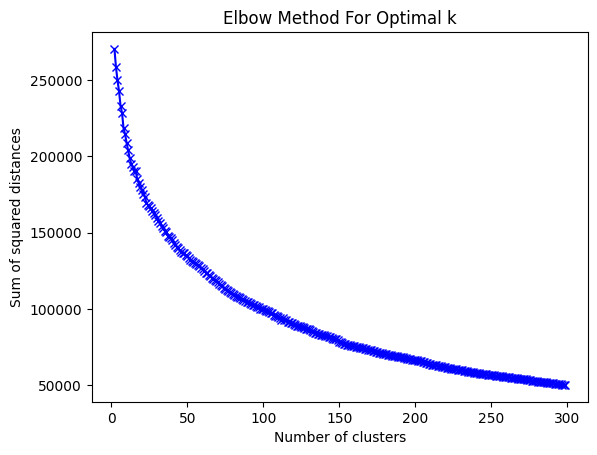

In [35]:
ssd = []
range_n_clusters = list(range(2, 300))
for num_clusters in tqdm(range_n_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=2024)
    kmeans.fit(four_days_data.drop(columns="csn"))
    ssd.append(kmeans.inertia_)

# Plot SSD for each n_clusters
plt.plot(range_n_clusters, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()
# plt.savefig('generated data/kmeans.png')

#### Do clustering

In [36]:
four_days_data

,temperature,map_line,map_cuff,pulse,unassisted_resp_rate,end_tidal_co2,o2_flow_rate,base_excess,bicarb_(hco3),blood_urea_nitrogen_(bun),...,erythrocyte_sedimentation_rate_(esr),gcs_total_score,best_map,pf_sp,pf_pa,spo2,partial_pressure_of_oxygen_(pao2),rass_score,CAM_ICU,csn
0,1.654985,1.543293,0.712217,1.037490,-0.277493,1.443907,-0.794470,-0.319874,-0.824496,0.070542,...,1.634933,-1.598843,1.475408,1.028444,-1.108899,-0.454683,-0.687484,-1.002158,1.311655,43640203
1,0.179388,0.036551,0.685907,-0.148586,-0.277493,1.223377,-0.794470,-0.319874,-0.880290,0.051429,...,1.634933,-1.598843,-0.011264,-1.524705,-1.093262,-0.158852,-0.640286,-0.579654,1.311655,43640203
2,-1.182702,0.325409,0.685907,-0.125951,-0.277493,1.100080,-0.794470,-0.319874,-0.746384,0.032315,...,1.634933,-1.598843,0.273745,-1.533378,-1.065115,-0.333475,-0.555330,-0.438819,1.311655,43640203
3,-0.501657,-0.420155,-0.300701,1.405686,-0.312486,0.691097,-0.794470,-0.319874,-1.023762,0.032315,...,1.634933,-0.534057,-0.461888,-1.533889,-1.087007,-0.343746,-0.621407,-0.016316,-0.279635,43640203
4,1.314463,-0.100070,0.093942,3.125949,-0.067534,0.817400,-0.794470,-0.319874,-0.387706,0.032315,...,1.634933,0.530729,0.115835,-0.819034,-0.562856,0.858066,-0.064474,1.673699,-0.810065,43640203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6098,-1.806994,-0.678342,-0.794005,-1.197343,-0.569101,-1.483133,-0.420393,-0.161775,-1.018979,0.041872,...,-0.428030,-0.179128,-0.789998,-0.819408,-0.058841,-0.917506,-0.028993,-0.579654,1.311655,70840791325
6099,-1.806994,-1.454576,-0.333588,-0.324637,-1.233969,-1.483133,-0.420393,-0.161775,-1.592864,0.070542,...,-0.428030,-0.652367,-1.124343,-0.819408,-0.058841,0.303384,-0.028993,-0.438819,1.311655,70840791325
6100,-1.863747,-1.169623,-0.826892,-1.393514,-1.607228,-1.483133,-0.420393,-0.161775,-1.592864,0.070542,...,-0.428030,0.294110,-1.201373,-0.819408,-0.058841,0.149305,-0.028993,-0.438819,1.311655,70840791325
6101,-1.977255,-0.954932,-0.563797,-1.114348,-1.589731,-1.483133,-0.420393,-0.161775,-1.592864,-0.005912,...,-0.428030,0.294110,-0.989541,-0.819408,-0.058841,0.036314,-0.028993,-0.438819,1.311655,70840791325


In [54]:
n_clusters = 30
# n_clusters = 50

kmeans = KMeans(n_clusters=n_clusters, random_state=2024)
clusters = kmeans.fit_predict(four_days_data.drop(columns='csn'))
four_days_data['cluster'] = clusters+1

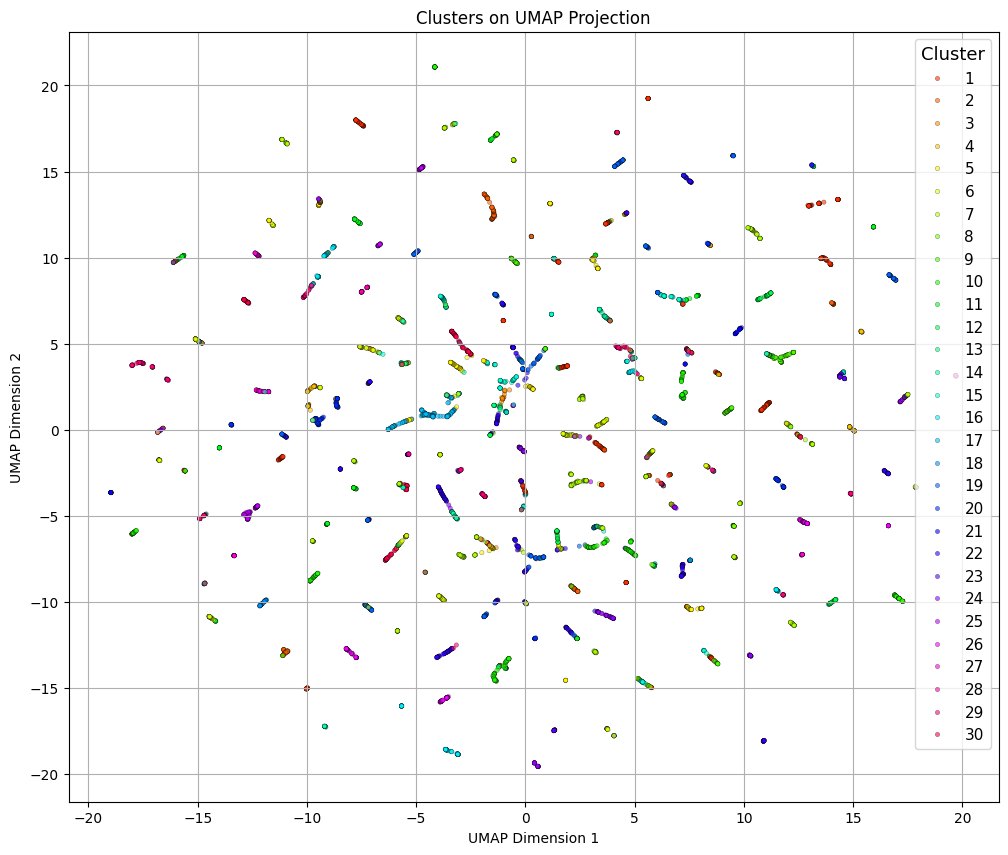

In [58]:
import umap
import seaborn as sns

# Initialize and fit UMAP
reducer = umap.UMAP(n_neighbors=10, random_state=42)
embedding = reducer.fit_transform(four_days_data.drop(columns=['csn', 'cluster']))

# Combine the embedding with your cluster data
plot_data = four_days_data.copy()
plot_data['UMAP-1'] = embedding[:, 0]
plot_data['UMAP-2'] = embedding[:, 1]

# Plotting using seaborn
plt.figure(figsize=(12, 10))
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='cluster', palette=sns.color_palette("hsv", n_clusters), data=plot_data, s=10, alpha=0.6, edgecolor='k')
plt.title('Clusters on UMAP Projection')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster', title_fontsize='13', fontsize='11', loc='upper right')
plt.grid(True)
plt.show()


In [61]:
four_days_data

,temperature,map_line,map_cuff,pulse,unassisted_resp_rate,end_tidal_co2,o2_flow_rate,base_excess,bicarb_(hco3),blood_urea_nitrogen_(bun),...,gcs_total_score,best_map,pf_sp,pf_pa,spo2,partial_pressure_of_oxygen_(pao2),rass_score,CAM_ICU,csn,cluster
0,1.654985,1.543293,0.712217,1.037490,-0.277493,1.443907,-0.794470,-0.319874,-0.824496,0.070542,...,-1.598843,1.475408,1.028444,-1.108899,-0.454683,-0.687484,-1.002158,1.311655,43640203,15
1,0.179388,0.036551,0.685907,-0.148586,-0.277493,1.223377,-0.794470,-0.319874,-0.880290,0.051429,...,-1.598843,-0.011264,-1.524705,-1.093262,-0.158852,-0.640286,-0.579654,1.311655,43640203,10
2,-1.182702,0.325409,0.685907,-0.125951,-0.277493,1.100080,-0.794470,-0.319874,-0.746384,0.032315,...,-1.598843,0.273745,-1.533378,-1.065115,-0.333475,-0.555330,-0.438819,1.311655,43640203,10
3,-0.501657,-0.420155,-0.300701,1.405686,-0.312486,0.691097,-0.794470,-0.319874,-1.023762,0.032315,...,-0.534057,-0.461888,-1.533889,-1.087007,-0.343746,-0.621407,-0.016316,-0.279635,43640203,10
4,1.314463,-0.100070,0.093942,3.125949,-0.067534,0.817400,-0.794470,-0.319874,-0.387706,0.032315,...,0.530729,0.115835,-0.819034,-0.562856,0.858066,-0.064474,1.673699,-0.810065,43640203,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6098,-1.806994,-0.678342,-0.794005,-1.197343,-0.569101,-1.483133,-0.420393,-0.161775,-1.018979,0.041872,...,-0.179128,-0.789998,-0.819408,-0.058841,-0.917506,-0.028993,-0.579654,1.311655,70840791325,24
6099,-1.806994,-1.454576,-0.333588,-0.324637,-1.233969,-1.483133,-0.420393,-0.161775,-1.592864,0.070542,...,-0.652367,-1.124343,-0.819408,-0.058841,0.303384,-0.028993,-0.438819,1.311655,70840791325,24
6100,-1.863747,-1.169623,-0.826892,-1.393514,-1.607228,-1.483133,-0.420393,-0.161775,-1.592864,0.070542,...,0.294110,-1.201373,-0.819408,-0.058841,0.149305,-0.028993,-0.438819,1.311655,70840791325,24
6101,-1.977255,-0.954932,-0.563797,-1.114348,-1.589731,-1.483133,-0.420393,-0.161775,-1.592864,-0.005912,...,0.294110,-0.989541,-0.819408,-0.058841,0.036314,-0.028993,-0.438819,1.311655,70840791325,24
